## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [205]:
from main import *
ari = ARI()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.0 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [206]:
case1, case2 = ari.load_data()

case1_qinv = ari.quadratic_inversion(case1)
case2_qinv = ari.quadratic_inversion(case2)

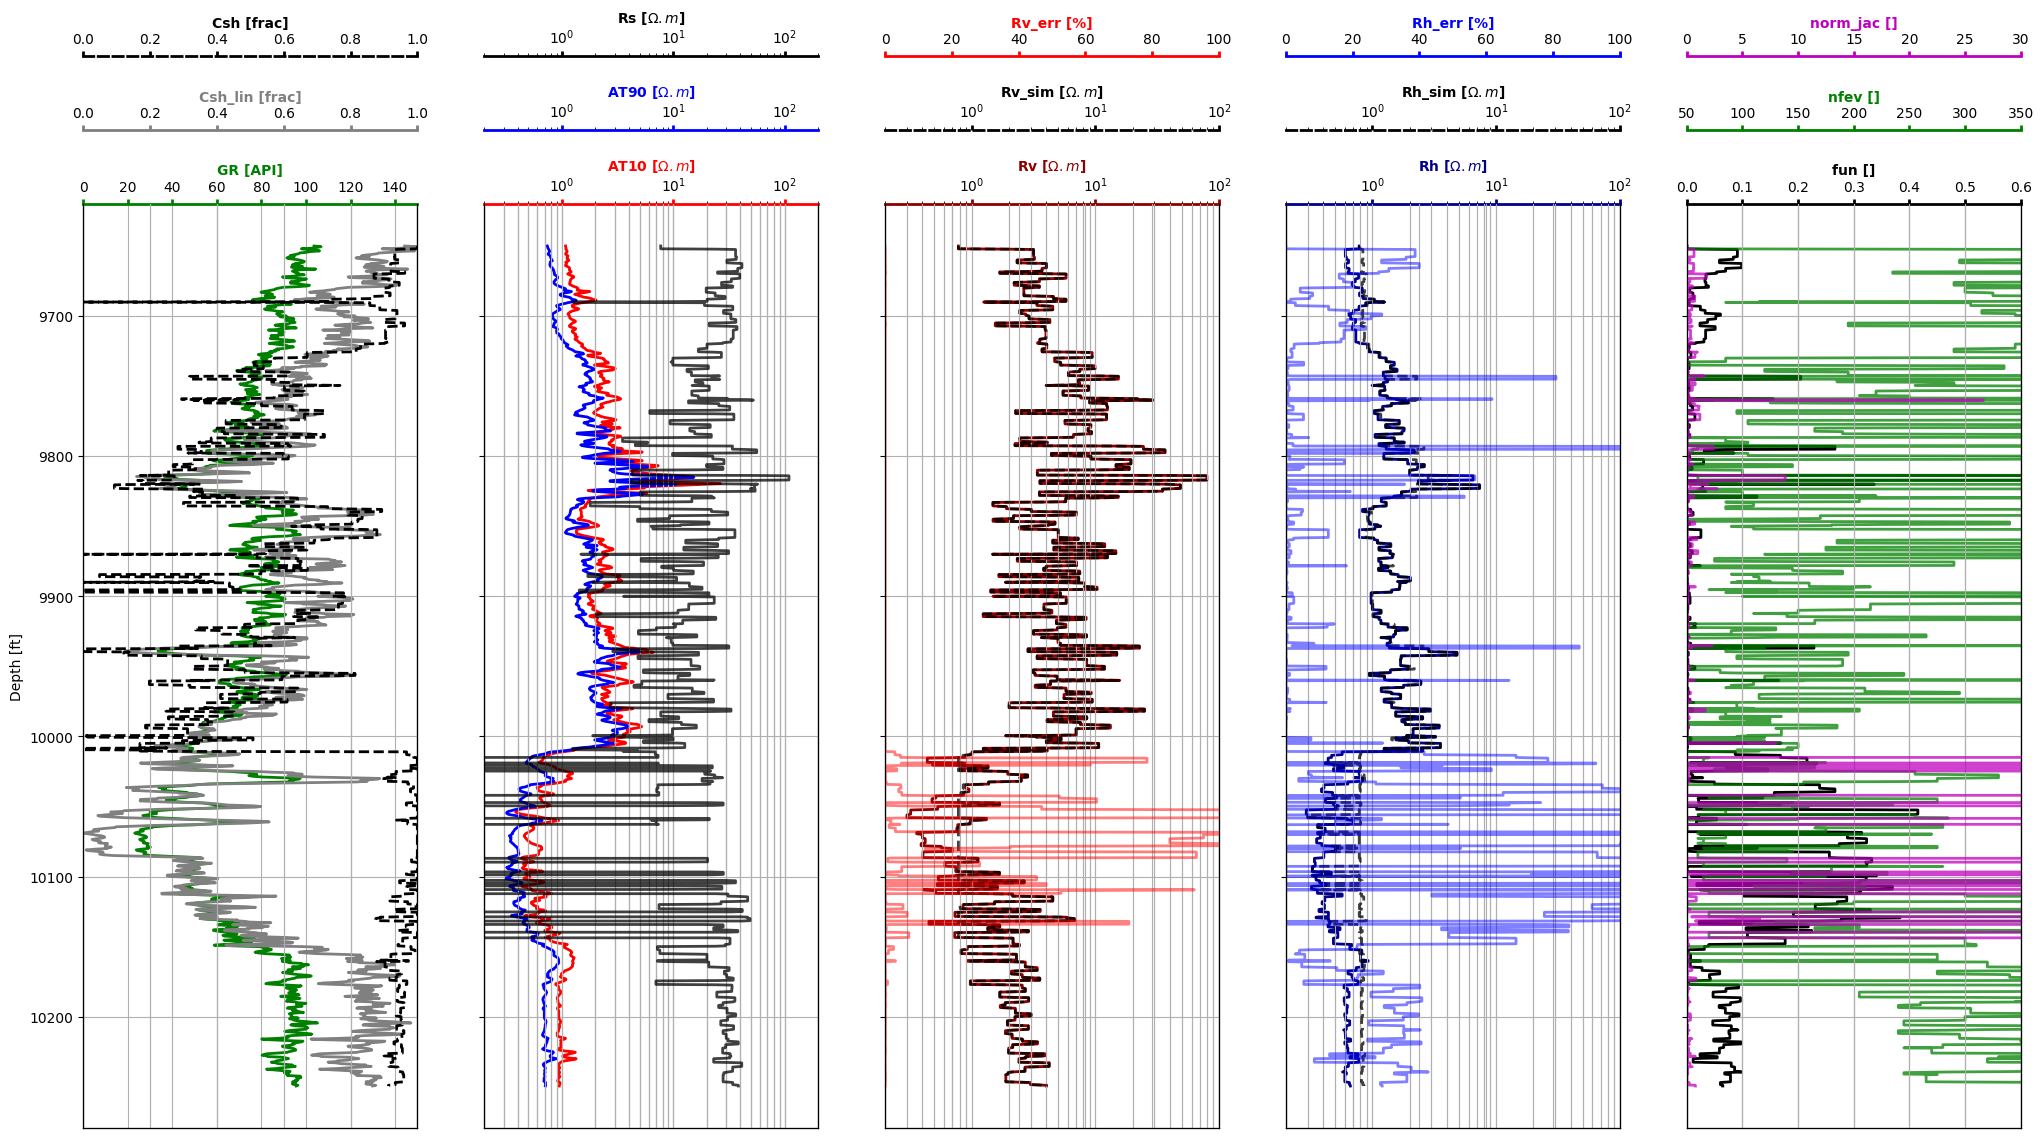

In [207]:
inv1 = ari.resistivity_inversion(case1)
ari.plot_inversion_results(inv1)

In [ ]:
inv2 = ari.resistivity_inversion(case2)
ari.plot_inversion_results(inv2)

***
# END

In [237]:
import torch
import torch.nn as nn

In [2]:
case1, case2 = ari.load_data()
case1.shape

(2399, 7)

In [384]:
class PINNari(nn.Module):
    def __init__(self):
        super(PINNari, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [382]:
class PhysicsLoss(nn.Module):
    def __init__(self, model, Rvsh, Rhsh):
        super(PhysicsLoss, self).__init__()
        self.model = model
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh

    def forward(self, Rv_true, Rh_true):
        Csh, Rs = self.model(torch.tensor([Rv_true, Rh_true], dtype=torch.float32))
        Csh = torch.sigmoid(Csh)
        Rs  = torch.abs(Rs)

        eq1 = Csh*self.Rvsh + (1-Csh)*Rs - Rv_true
        eq2 = Csh/self.Rhsh + (1-Csh)/Rs - 1/Rh_true

        loss = (eq1/Rv_true)**2 + (eq2/Rh_true)**2
        return loss

In [383]:
res_aniso = case1[['Rv','Rh']]
Rvsh, Rhsh = np.percentile(res_aniso['Rv'], 90), np.percentile(res_aniso['Rh'], 90)

model     = PINNari()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = PhysicsLoss(model, Rvsh, Rhsh)

epochs = 20
for _, row in res_aniso.iterrows():
    Rv_true, Rh_true = row['Rv'], row['Rh']
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = criterion(Rv_true, Rh_true)
        loss.backward()
        optimizer.step()

adjoints = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        adjoints[name] = param.grad.clone().detach()

IndexError: Dimension specified as -1 but tensor has no dimensions

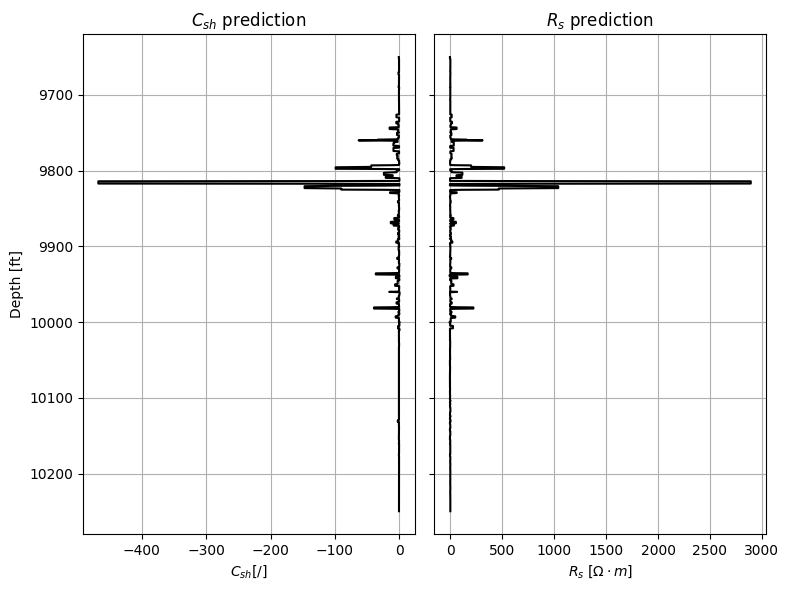

In [368]:
pred = model(torch.tensor(case1[['Rv','Rh']].values, dtype=torch.float32))
csh_pred = pred[:,1].detach().numpy()
rs_pred  = pred[:,0].detach().numpy()

fig, axs = plt.subplots(1,2,figsize=(8,6), sharey=True)
ax1, ax2 = axs
ax1.plot(csh_pred, case1.index, color='k')
ax1.set(title='$C_{sh}$ prediction', xlabel='$C_{sh} [/]$', ylabel='Depth [ft]')
ax2.plot(rs_pred,  case1.index, color='k')
ax2.set(title='$R_s$ prediction', xlabel='$R_s$ [$\Omega \cdot m$]')
[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout(); plt.show()